# Bozza Random forest

Random forest fatta così non ha un cazzo di senso.
Avrà senso aggiungere la Z insieme ai dati e fare un unico grande dataset.
Dopodiche si può fare PCA, per scartare le componenti a due a due mega correlate, visto che rappresenteranno più o meno la stessa grandezza fisica.
Così possiamo ridurre il numero di features e rimane computaizonemlmente meno intensivo.

Altra cosa Mrem secondo me è una buona feature che racchiude varie cose, Dipende da Z, natal kick, m1, m2.

#### qui sopra non si è mai trattato di metallicità. qui sotto inserisco la metallicità in ogni dataset e li unisco tutti e rifaccio l'algoritmo

In [1]:
import pandas as pd
import polars as pl
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.scale import FuncScale

In [2]:
heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen']

path_data = './data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.
cols = [1,2,3,4,9,13,14,15,16,17,25,27]


In [3]:
def extractor(path_data=path_data, cluster):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data) #check what your pc does here
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + dyn + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heade)#, names=heade)
        #dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        #dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
        data = data[data['t_elapsed'] != 136000]
    return data

### ML 

##### Ho pensato che feature che sono importanti da usare come target sono la massa del buco nero, quale caratteristica è più identificativa di un buco nero del resto, ma anche la feature GEN, generazione del buco nero. ci interessa anche questa.


vedi cosa succede per gen = o > 2

abs(spin1-spin2)


Potremmo dire che m1 e m2 sono praticamente cosa fanno la Mrem, pero siccome c'è una piccola variazione tipo si potrebbe dire che oltre a quello ci sono questi fattori



In [4]:
def rndmfrst(cluster, listwhattodrop, target, n_estimators=50, max_depth=20, random_state=42, n_jobs=6, cv=5):
    dataysc = extractor(path_data, cluster)
    #dataysc['DiffSpin'] = abs(dataysc.S2 - dataysc.S1)
    df = dataysc.drop(columns=listwhattodrop)
    del dataysc

    feature_names = list(df.columns)
    feature_names.remove(target)

    X = df.drop(columns=target)
    y = df[target]

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', model)])

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
        'rmse': make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))  # RMSE
    }

    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, return_estimator=True)

    # Compute mean and std for each metric
    print(f"Cross-Validation ({cv}-fold) Results:")
    print(f"R² Score: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
    print(f"MAE: {cv_results['test_mae'].mean():.4f} ± {cv_results['test_mae'].std():.4f}")
    print(f"MSE: {cv_results['test_mse'].mean():.4f} ± {cv_results['test_mse'].std():.4f}")
    print(f"RMSE: {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")

    best_estimator = cv_results['estimator'][np.argmax(cv_results['test_r2'])]  # Choose model with highest R²
    feature_importances = best_estimator.named_steps['regressor'].feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance Score")
    plt.title(f"Feature Importance in Predicting Final Black Hole Mass in {cluster}s")
    plt.show()

    return 'done'


Cross-Validation (5-fold) Results:
R² Score: 0.9981 ± 0.0013
MAE: 0.6043 ± 0.1124
MSE: 2.7982 ± 2.2611
RMSE: 1.5516 ± 0.6252


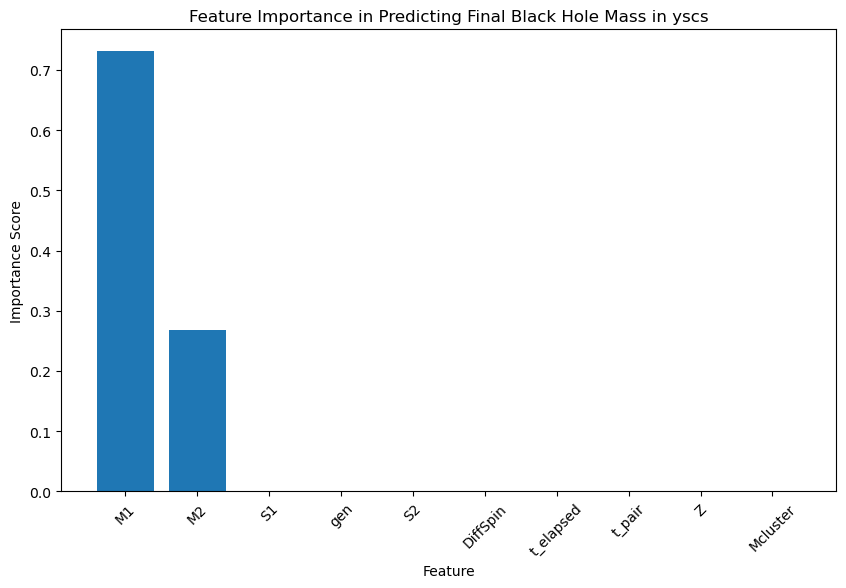

'done'

In [5]:
rndmfrst('ysc',['Srem', 'esca_v','kick'], 'Mrem' )

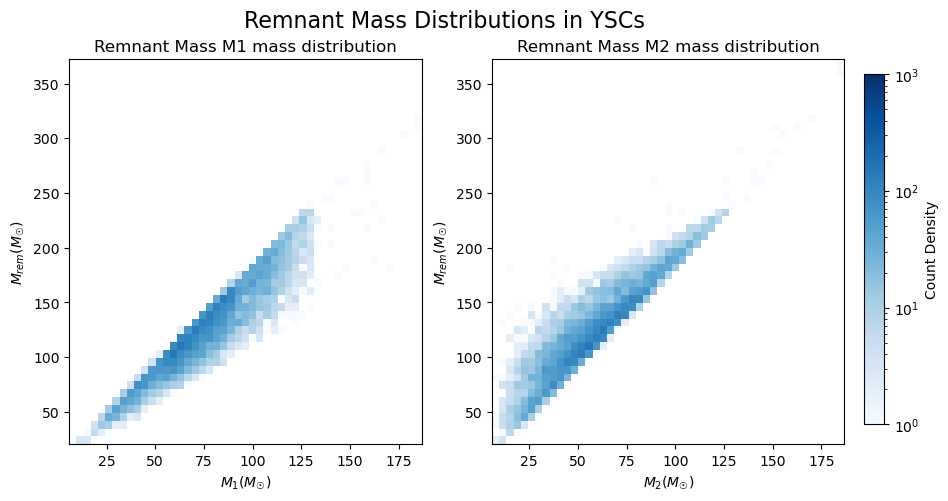

In [16]:
data = extractor(path_data, 'ysc')

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Remnant Mass Distributions in YSCs", fontsize=16)
#Select first panel
## Create custom log bins for period and masses
Rem_bins = np.linspace(data.Mrem.min(),data.Mrem.max(),50) 
M_bins = np.linspace(data.M2.min(),data.M2.max(),50)
plt.sca(ax[0])
hist = plt.hist2d(data.M1,data.Mrem,bins=(M_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass M1 mass distribution')
plt.xlabel(u'$M_1 (M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')


plt.sca(ax[1])
plt.hist2d(data.M2,data.Mrem,bins=(M_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass M2 mass distribution')
plt.xlabel(u'$M_2 (M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")

plt.show()
del data

Cross-Validation (5-fold) Results:
R² Score: 0.5403 ± 0.0718
MAE: 20.1526 ± 0.9737
MSE: 639.3459 ± 49.2569
RMSE: 25.2663 ± 0.9810


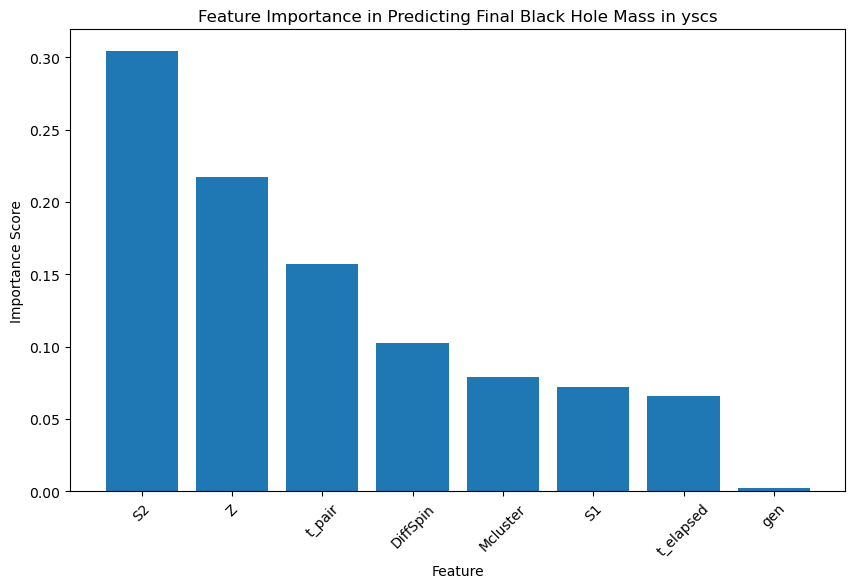

'done'

In [6]:
rndmfrst('ysc',['M1', 'M2','Srem', 'esca_v','kick'], 'Mrem' )

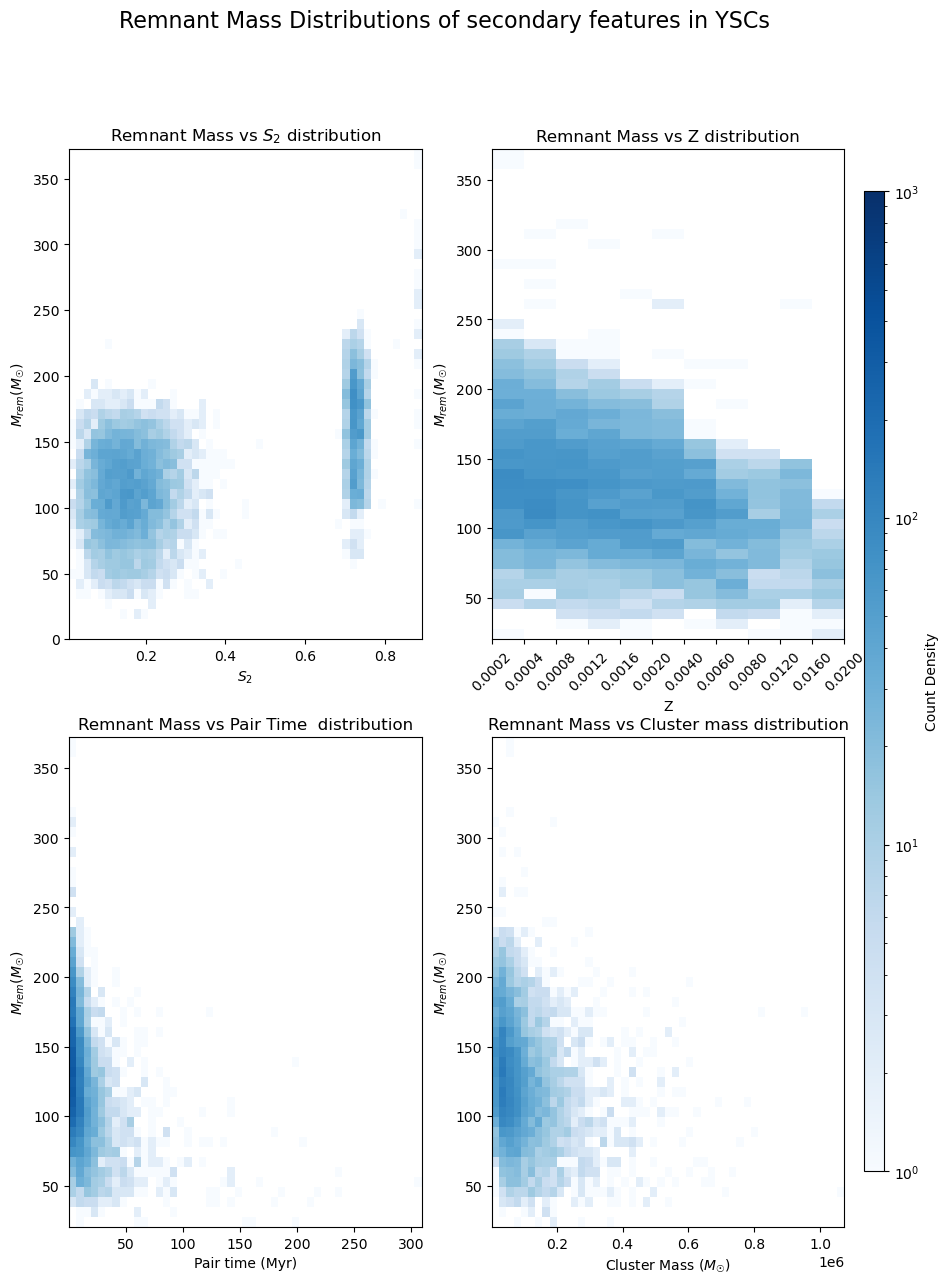

In [44]:
data = extractor(path_data, 'ysc')

fig, ax = plt.subplots(2,2,figsize=(10,14))
fig.suptitle("Remnant Mass Distributions of secondary features in YSCs", fontsize=16)
Rem_bins = np.linspace(0,data.Mrem.max(),50) 
plt.sca(ax[0,0])
spin_bins = np.linspace(data.S2.min(),data.S2.max(),50)
hist = plt.hist2d(data.S2,data.Mrem,bins=(spin_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs $S_{2}$ distribution')
plt.xlabel(u'$S_2$')
plt.ylabel(u'$M_{rem} (M_\u2609$)')


plt.sca(ax[0,1])
z_bins = np.array([2e-4, 4e-4, 8e-4, 12e-4, 16e-4, 2e-3, 4e-3, 6e-3, 8e-3, 12e-3, 16e-3, 2e-2])
Rem_bins = np.linspace(data.Mrem.min(),data.Mrem.max(),50) 
plt.hist2d(data.Z,data.Mrem, bins=(z_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))

def forward(x):
    return np.interp(x, z_bins, np.arange(len(z_bins)))

def inverse(x):
    return np.interp(x, np.arange(len(z_bins)), z_bins)

# Create the FuncScale object correctly
scale = FuncScale(ax[0, 1].xaxis, (forward, inverse))

# Apply the scale to the x-axis
ax[0, 1].set_xscale('function', functions=(forward, inverse))
# Set custom tick positions and labels
plt.xticks(z_bins, rotation=45)
# Set y-axis scale
plt.yscale("linear")
plt.title('Remnant Mass vs Z distribution')
plt.xlabel(u'Z')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

plt.sca(ax[1,0])
t_pair_bins = np.linspace(data.t_pair.min(), data.t_pair.max(),50)
plt.hist2d(data.t_pair,data.Mrem,bins=(t_pair_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs Pair Time  distribution')
plt.xlabel(u'Pair time (Myr)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

plt.sca(ax[1,1])
Cl_bins = np.linspace(data.Mcluster.min(),data.Mcluster.max(),50)
plt.hist2d(data.Mcluster,data.Mrem,bins=(Cl_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs Cluster mass distribution')
plt.xlabel(u'Cluster Mass $(M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")

plt.show()

Cross-Validation (5-fold) Results:
R² Score: 0.9997 ± 0.0002
MAE: 0.1488 ± 0.0161
MSE: 0.5244 ± 0.4307
RMSE: 0.6439 ± 0.3315


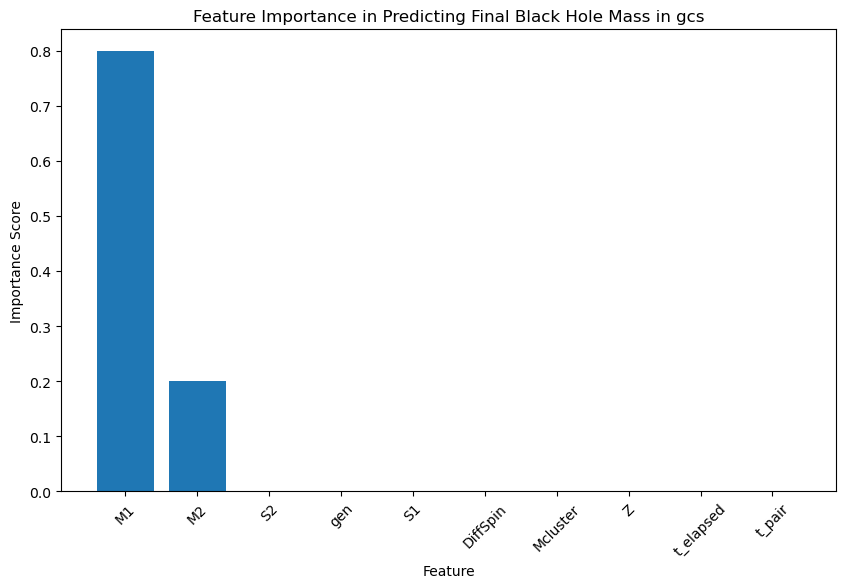

'done'

In [12]:
rndmfrst('gc',['Srem', 'esca_v','kick'], 'Mrem',n_estimators=70, max_depth=20, random_state=42, n_jobs=-1, cv=5  )
#rndmfrst?

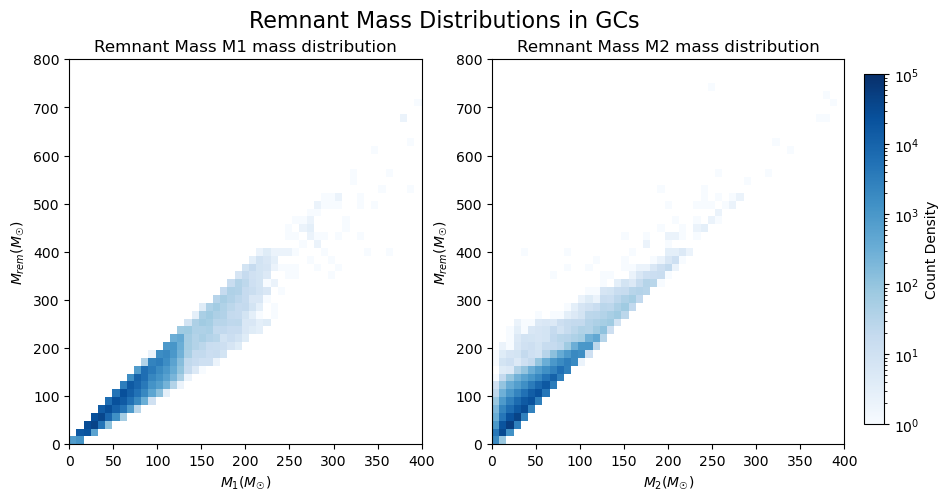

In [20]:
data = extractor(path_data, 'gc')

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Remnant Mass Distributions in GCs", fontsize=16)
#Select first panel
## Create custom log bins for period and masses
Rem_bins = np.linspace(0,800,50) 
M_bins = np.linspace(0,400,50)
plt.sca(ax[0])
hist = plt.hist2d(data.M1,data.Mrem,bins=(M_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass M1 mass distribution')
plt.xlabel(u'$M_1 (M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')


plt.sca(ax[1])
plt.hist2d(data.M2,data.Mrem,bins=(M_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass M2 mass distribution')
plt.xlabel(u'$M_2 (M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
del data

Cross-Validation (5-fold) Results:
R² Score: 0.6572 ± 0.0671
MAE: 18.3345 ± 2.4164
MSE: 605.7511 ± 193.9914
RMSE: 24.2933 ± 3.9481


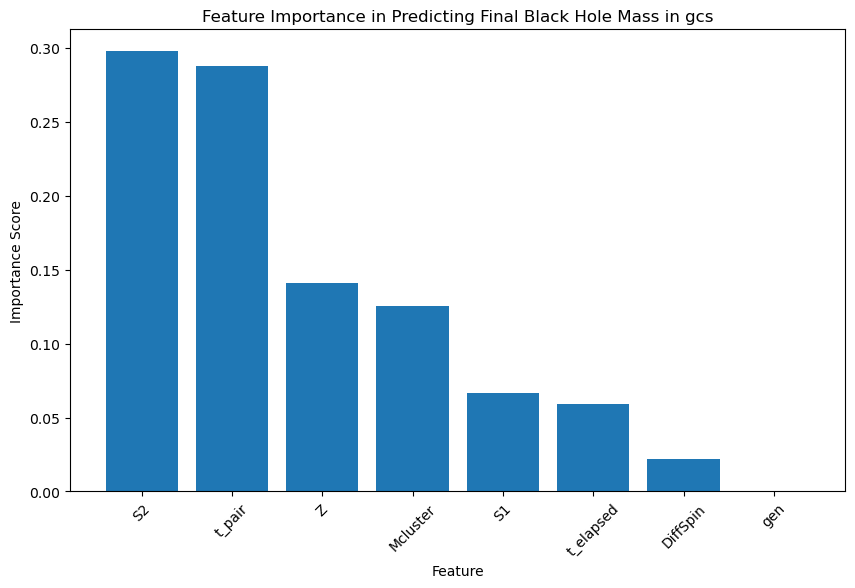

'done'

In [21]:
rndmfrst('gc',['M1', 'M2','Srem', 'esca_v','kick'], 'Mrem' )

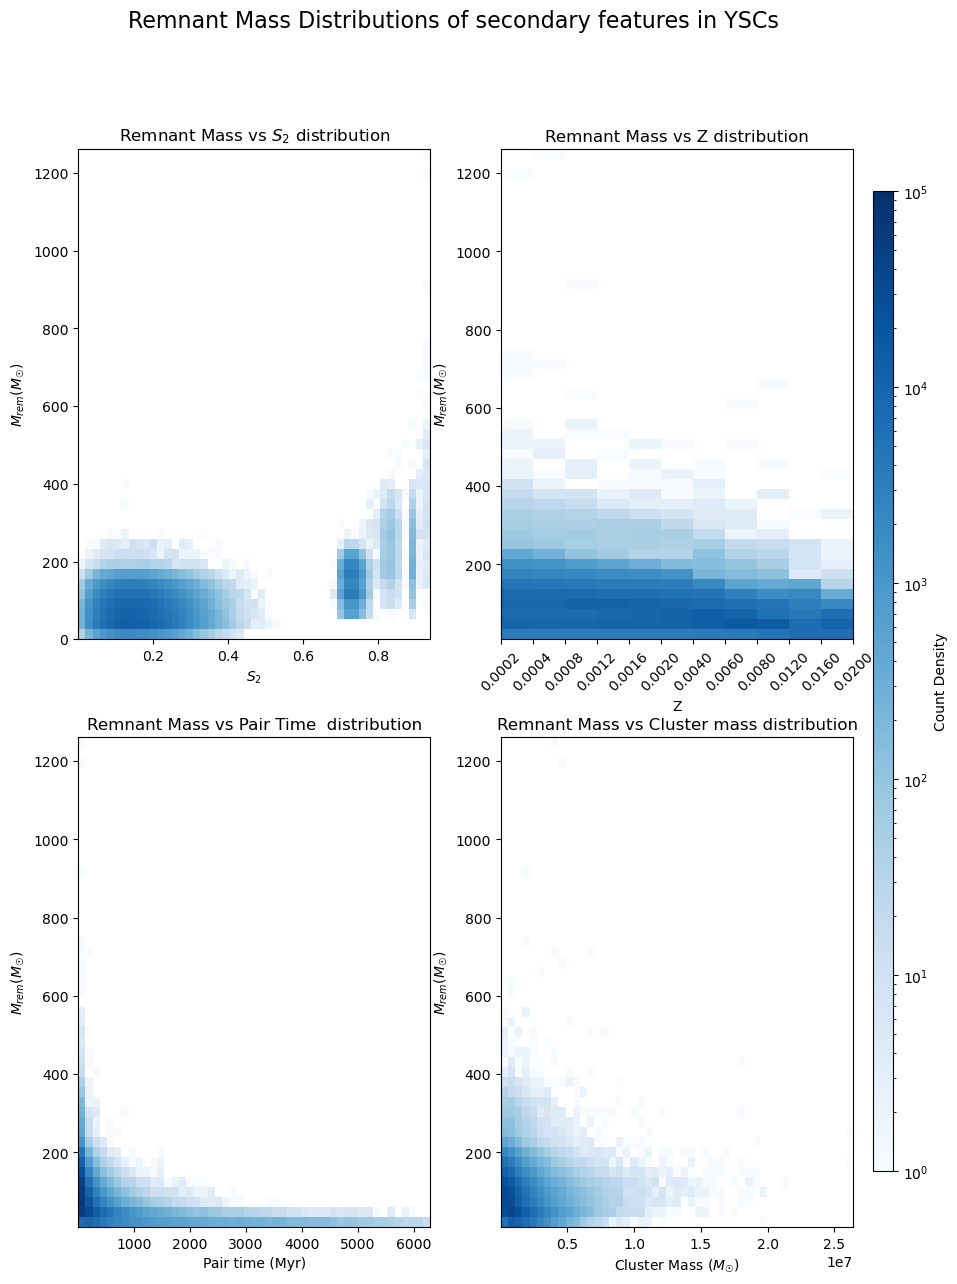

In [23]:
data = extractor(path_data, 'gc')

fig, ax = plt.subplots(2,2,figsize=(10,14))
fig.suptitle("Remnant Mass Distributions of secondary features in GCs", fontsize=16)
Rem_bins = np.linspace(0,800,50) 
plt.sca(ax[0,0])
spin_bins = np.linspace(data.S2.min(),data.S2.max(),50)
hist = plt.hist2d(data.S2,data.Mrem,bins=(spin_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs $S_{2}$ distribution')
plt.xlabel(u'$S_2$')
plt.ylabel(u'$M_{rem} (M_\u2609$)')


plt.sca(ax[0,1])
z_bins = np.array([2e-4, 4e-4, 8e-4, 12e-4, 16e-4, 2e-3, 4e-3, 6e-3, 8e-3, 12e-3, 16e-3, 2e-2])
Rem_bins = np.linspace(data.Mrem.min(),data.Mrem.max(),50) 
plt.hist2d(data.Z,data.Mrem, bins=(z_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))

def forward(x):
    return np.interp(x, z_bins, np.arange(len(z_bins)))

def inverse(x):
    return np.interp(x, np.arange(len(z_bins)), z_bins)

# Create the FuncScale object correctly
scale = FuncScale(ax[0, 1].xaxis, (forward, inverse))

# Apply the scale to the x-axis
ax[0, 1].set_xscale('function', functions=(forward, inverse))
# Set custom tick positions and labels
plt.xticks(z_bins, rotation=45)
# Set y-axis scale
plt.yscale("linear")
plt.title('Remnant Mass vs Z distribution')
plt.xlabel(u'Z')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

plt.sca(ax[1,0])
t_pair_bins = np.linspace(data.t_pair.min(), data.t_pair.max(),50)
plt.hist2d(data.t_pair,data.Mrem,bins=(t_pair_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs Pair Time  distribution')
plt.xlabel(u'Pair time (Myr)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

plt.sca(ax[1,1])
Cl_bins = np.linspace(data.Mcluster.min(),data.Mcluster.max(),50)
plt.hist2d(data.Mcluster,data.Mrem,bins=(Cl_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs Cluster mass distribution')
plt.xlabel(u'Cluster Mass $(M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")

plt.show()

Cross-Validation (3-fold) Results:
R² Score: 0.9966 ± 0.0030
MAE: 0.8885 ± 0.2542
MSE: 11.8717 ± 11.0527
RMSE: 3.0907 ± 1.5230


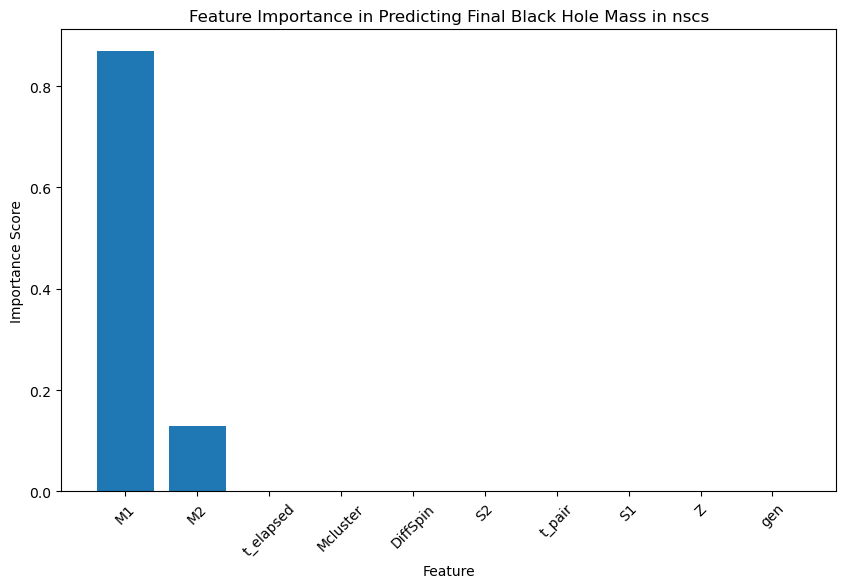

'done'

In [25]:
rndmfrst('nsc',['Srem', 'esca_v','kick'], 'Mrem', n_estimators=50, max_depth=10, cv=3 )


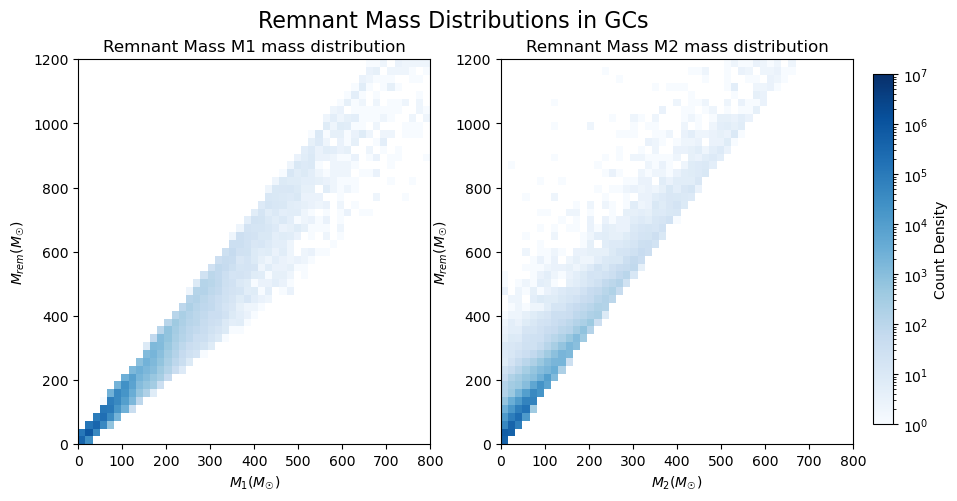

In [27]:
data = extractor(path_data, 'nsc')

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Remnant Mass Distributions in NSCs", fontsize=16)
#Select first panel
## Create custom log bins for period and masses
Rem_bins = np.linspace(0,1200,50) 
M_bins = np.linspace(0,800,50)
plt.sca(ax[0])
hist = plt.hist2d(data.M1,data.Mrem,bins=(M_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e7))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass M1 mass distribution')
plt.xlabel(u'$M_1 (M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')


plt.sca(ax[1])
plt.hist2d(data.M2,data.Mrem,bins=(M_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e7))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass M2 mass distribution')
plt.xlabel(u'$M_2 (M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
del data

Cross-Validation (5-fold) Results:
R² Score: 0.7919 ± 0.0188
MAE: 14.3212 ± 1.8918
MSE: 667.5369 ± 259.0056
RMSE: 25.2501 ± 5.4742


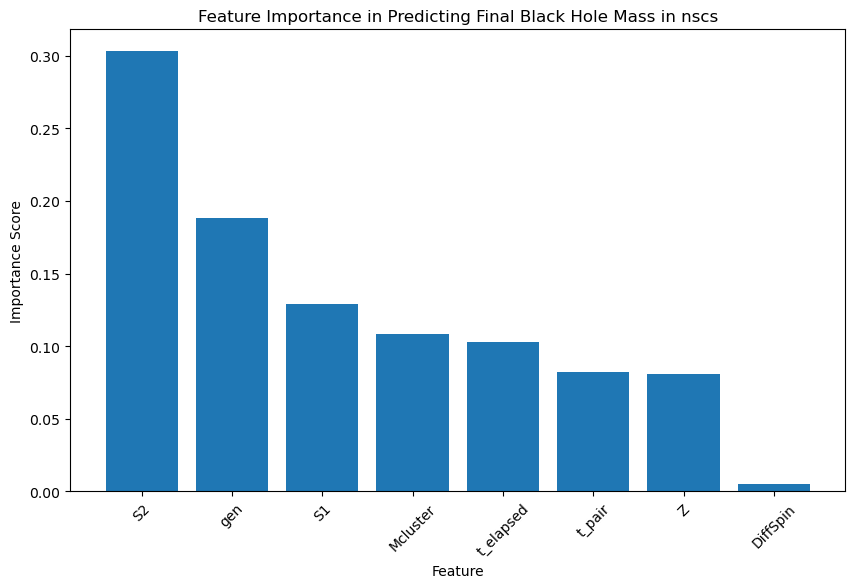

'done'

In [28]:
rndmfrst('nsc',['M1', 'M2', 'Srem', 'esca_v','kick'], 'Mrem' ,  n_estimators=50, max_depth=10, random_state=42, n_jobs=6, cv=5)

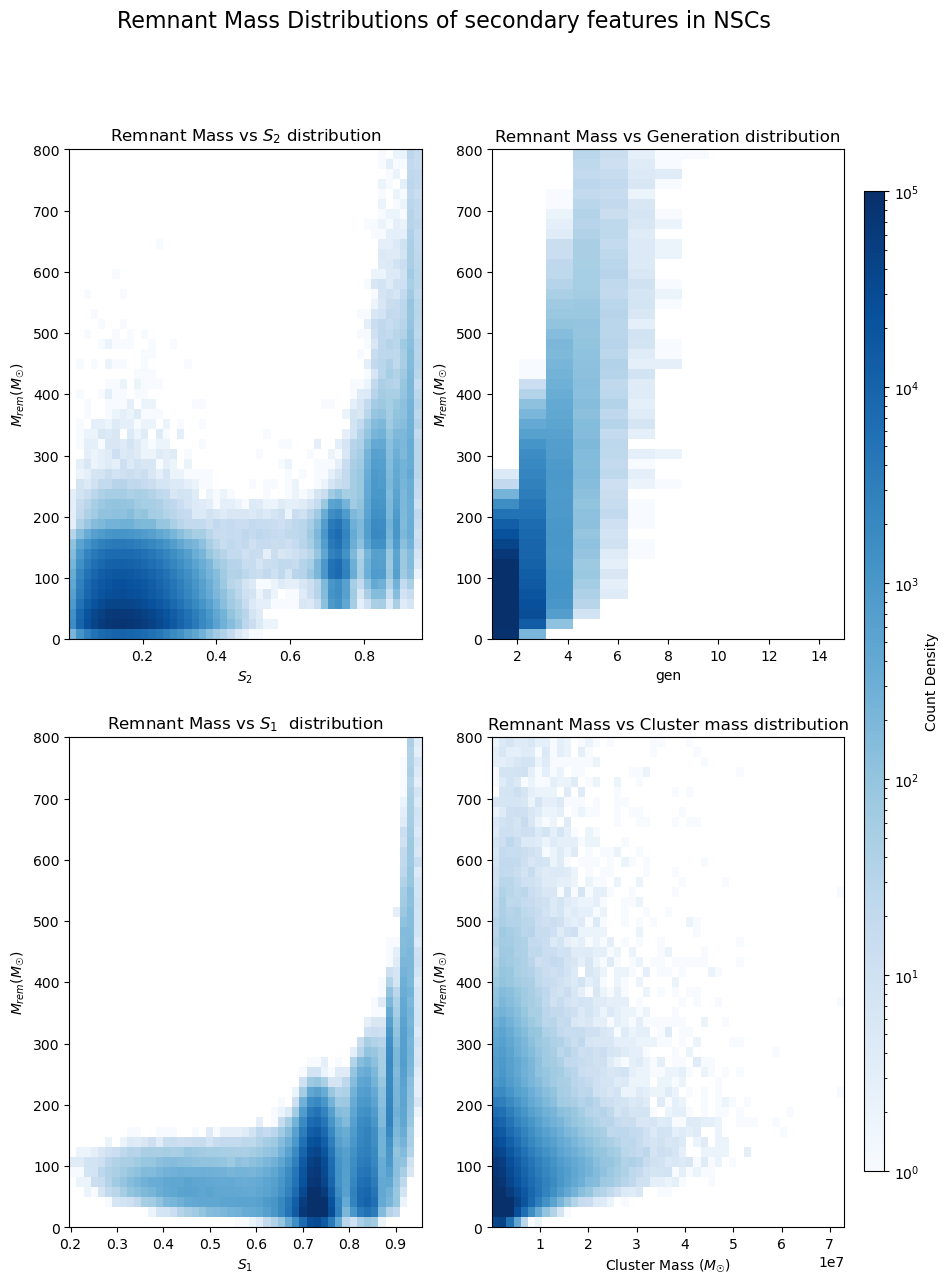

In [32]:
data = extractor(path_data, 'nsc')

fig, ax = plt.subplots(2,2,figsize=(10,14))
fig.suptitle("Remnant Mass Distributions of secondary features in NSCs", fontsize=16)
Rem_bins = np.linspace(0,800,50) 
plt.sca(ax[0,0])
spin_bins = np.linspace(data.S2.min(),data.S2.max(),50)
hist = plt.hist2d(data.S2,data.Mrem,bins=(spin_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs $S_{2}$ distribution')
plt.xlabel(u'$S_2$')
plt.ylabel(u'$M_{rem} (M_\u2609$)')


plt.sca(ax[0,1])
gen_bins = np.linspace(1,15,14)
hist = plt.hist2d(data.gen,data.Mrem,bins=(gen_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs Generation distribution')
plt.xlabel(u'gen')
plt.ylabel(u'$M_{rem} (M_\u2609$)')


plt.sca(ax[1,0])
s1_bins = np.linspace(data.S1.min(), data.S1.max(),50)
plt.hist2d(data.S1,data.Mrem,bins=(s1_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs $S_{1}$  distribution')
plt.xlabel(u'$S_1$')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

plt.sca(ax[1,1])
Cl_bins = np.linspace(data.Mcluster.min(),data.Mcluster.max(),50)
plt.hist2d(data.Mcluster,data.Mrem,bins=(Cl_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e5))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Remnant Mass vs Cluster mass distribution')
plt.xlabel(u'Cluster Mass $(M_\u2609$)')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")

plt.show()

In [ ]:
## Interessante. Lo spin si riferisce a una componente dello spin che è perpendicolare al piano orbitale del sistema. Di conseguenza alto spin comporta una o più
# perturbazioni di una certa entità, ergo, interazioni dinamiche con altri oggetti del cluster. E' chiaro che maggiori sono le interazioni maggiori sono le possibilità di merge
# Stessa cosa è T-elapsed. CHè è il tempo che passa dalla formazione dei genitori di prima generazione al BH di n-esima generazione. Più tempo passa più sono probabili interazioni 
#dinamiche e merge gerarchici.
# Z sappiamo bene che è parte integrante della funzione di massa dei buchi neri.
# Escape velocity può essere importante come indicatore di permamenza nel cluster.

In [ ]:
## Come prima La componente di spin perpendicolare al piano orbitale è forte indicatore di interazioni con altri elementi del cluster. è più importante S1 rispetto a S2
# probabilmente perchè perturbare il corpo primario, non lo so.
# Mrem è chiaro invece dai.

RFR: 1.0
Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0
R² Score: 1.0


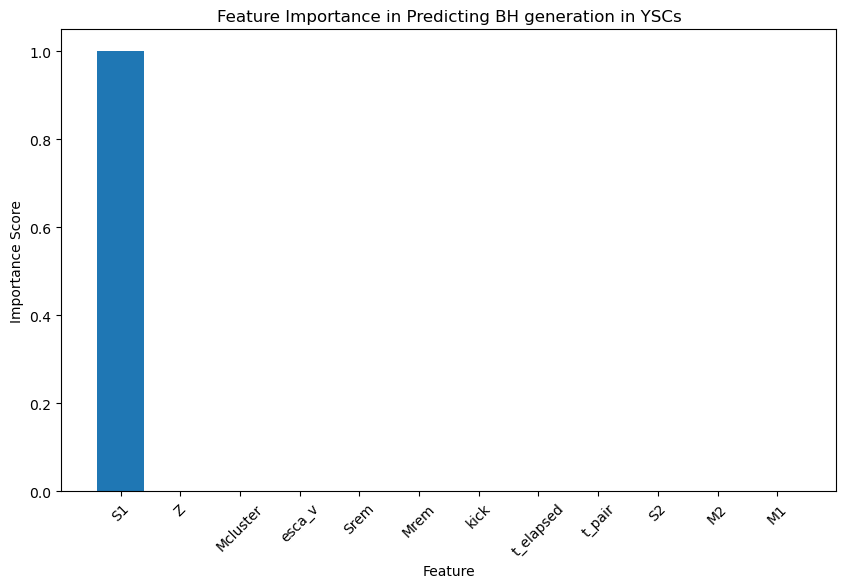

In [43]:
dataysc = extractor(path_data, 'ysc')

df = dataysc

colonne = list(df.columns)

targetcol = str('gen')

X = df.drop(columns=targetcol)
y = df[targetcol]
colonne.remove(targetcol)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=6)

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', model)])

pipeline.fit(X_train, y_train)

r2 = pipeline.score(X_test, y_test)

print(f"RFR: {r2}") 
#Prediction on test set
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {mse ** 0.5}")
print(f"R² Score: {r2}")

feature_importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = colonne

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Predicting BH generation in YSCs")
plt.show()

In [ ]:
datagc = extractor(path_data, 'gc')
df = datagc
del datagc


colonne = list(df.columns)

targetcol = str('gen')

X = df.drop(targetcol)
y = df[targetcol]
colonne.remove(targetcol)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=6)

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', model)])

pipeline.fit(X_train, y_train)

r2 = pipeline.score(X_test, y_test)

print(f"RFR: {r2}") 
#Prediction on test set
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {mse ** 0.5}")
print(f"R² Score: {r2}")

feature_importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = colonne

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Predicting Final Black Hole Mass in YSCs")
plt.show()




In [ ]:
datansc = extractor(path_data, 'nsc')
df = datansc
del datansc


colonne = list(df.columns)

targetcol = str('gen')

X = df.drop(targetcol)
y = df[targetcol]
colonne.remove(targetcol)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=6)

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', model)])

pipeline.fit(X_train, y_train)

r2 = pipeline.score(X_test, y_test)

print(f"RFR: {r2}") 
#Prediction on test set
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {mse ** 0.5}")
print(f"R² Score: {r2}")

feature_importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = colonne

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Predicting Final Black Hole Mass in YSCs")
plt.show()




In [ ]:
Classifier si può fare con quelli che escono / non escono

#### PCA

In [ ]:


def normer_col(df,i):
    media = df[i].mean()
    std = df[i].std()
    coso = (df[i] - media)/std
    return coso

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
heade = list(df.columns)
matrix = np.zeros((len(heade), len(heade)))
for i in heade:
    a = heade.index(i)
    inorm = normer_col(df,i)
    for j in heade:
        #if i !=j:
        b = heade.index(j)
        jnorm = normer_col(df,j)
        #print(i,j)            
        c = np.cov(inorm, jnorm)[0,1]
        if i=='M1' and j =='M2':
            print(c)
        #print(np.cov(inorm, jnorm)[0,1])
        matrix[b,a] = c
            
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
x = x.flatten()
y = y.flatten()
values = matrix.flatten()

ticks = np.linspace(-0.5,11.5,1)
# Create a 2D histogram
plt.hist2d(x,y, weights=values, bins=(matrix.shape[1], matrix.shape[0]), cmap='viridis')
plt.colorbar(label='Covariance')
plt.xticks(ticks=np.arange(len(heade)), labels=heade, rotation=90)  # Tick for each bin, labeled with `heade`
plt.yticks(ticks=np.arange(len(heade)), labels=heade)
#plt.ylabel(heade.index())
plt.show()


Ora , siccome alta correlazione significa che le quantità indicano più o meno la stessa grandezza e viceversa bassissima sono l'una l'inverso dell'altra, seleziono le features che hanno una correlazione compresa tra abs(0.6).
Tipo si vede che M1 e M2 hanno la stessa identica relaziono con praticamente tutte le quantità, E sono fortemente correlate con Mrem, per cui si potrebbe ridurre le features tralasciando M2 e M1 e tenendo Mrem.  S1 ha una correlazione nulla con ciascuna feature, per cui non sembra eliminabile; stessa cosa per S2. 
Per Z vediamo che corrisponde alla teoria, è inversamente proporzionale alle masse e alla massa del remnant. Il t_pair, tempo di accoppiamento è giustamente inversamente proporzionale alle masse.
T_elapsed non lo so perchè sia fortemente inv-correlato con lo spin del remnant. Escape velocity è inversamente correlato alle singole masse e direttamente alla massa totale. La generazione del buco nero è debolmente correlata a tutto, tranne che allo spin. NOn so a livello fisico cosa faccia lo spin però.

In [63]:
todo : aggiungere escape velocity

SyntaxError: invalid syntax (1812459419.py, line 1)

In [5]:
# Siccome M1,M2 sono estremamnte correlate magari prendere il rapporto tra le due potrebbe essere interessante
df= extractor(path_data, 'gc')
df = df[['M1', 'M2','Mrem', 'S1', 'S2','Srem','gen', 't_pair', 't_elapsed','kick', 'esca_v', 'Mcluster','Z'] ] # Reorder columns

In [6]:
def normer_col(df,i):
    media = df[i].mean()
    std = df[i].std()
    coso = (df[i] - media)/std
    return coso

0.8352350269111958


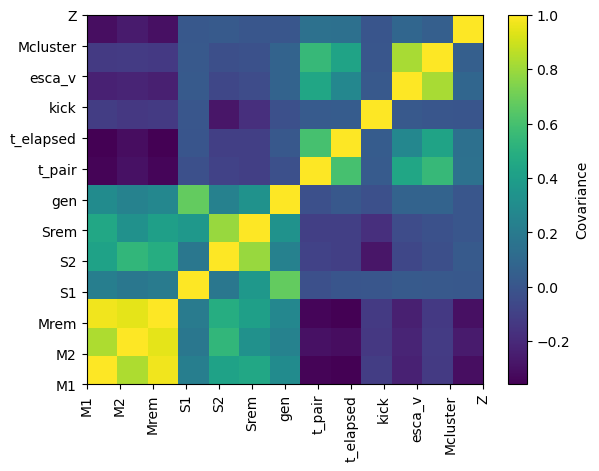

In [7]:
import matplotlib.pyplot as plt
import numpy as np
heade = list(df.columns)
matrix = np.zeros((len(heade), len(heade)))
for i in heade:
    a = heade.index(i)
    inorm = normer_col(df,i)
    for j in heade:
        #if i !=j:
        b = heade.index(j)
        jnorm = normer_col(df,j)
        #print(i,j)            
        c = np.cov(inorm, jnorm)[0,1]
        if i=='M1' and j =='M2':
            print(c)
        #print(np.cov(inorm, jnorm)[0,1])
        matrix[b,a] = c
            
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
x = x.flatten()
y = y.flatten()
values = matrix.flatten()

ticks = np.linspace(-0.5,11.5,1)
# Create a 2D histogram
plt.hist2d(x,y, weights=values, bins=(matrix.shape[1], matrix.shape[0]), cmap='viridis')
plt.colorbar(label='Covariance')
plt.xticks(ticks=np.arange(len(heade)), labels=heade, rotation=90)  # Tick for each bin, labeled with `heade`
plt.yticks(ticks=np.arange(len(heade)), labels=heade)
#plt.ylabel(heade.index())
plt.show()


#### PCA

scegliere una perentuale di varianza del dataset e la pca ti mantiene quello.